In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0" 

## Image Classification Example



We will begin our image classification example by importing some required modules.

In [2]:
import ktrain
from ktrain import vision as vis

Next, we will load and preprocess the image data for training and validation.  *ktrain* can load images and associated labels from a variety of source:


- `images_from_folder`:  labels are represented as subfolders containing images [ [example notebook] ](https://github.com/amaiya/ktrain/blob/master/examples/vision/dogs_vs_cats-ResNet50.ipynb)
- `images_from_csv`: labels are mapped to images in a CSV file [ [example notebook](https://github.com/amaiya/ktrain/blob/master/examples/vision/planet-ResNet50.ipynb) ]
- `images_from_fname`: labels are included as part of the filename and must be extracted using a regular expression [ [example notebook](https://github.com/amaiya/ktrain/blob/master/examples/vision/pets-ResNet50.ipynb) ]
- `images_from_array`: images and labels are stored in array [ [example notebook](https://github.com/amaiya/ktrain/blob/master/examples/vision/mnist-images_from_array_example.ipynb) ]


Here, we use the ```images_from_folder``` function to load the data as a generator (i.e., DirectoryIterator object).  This function assumes the following directory structure:
```
  ├── datadir
    │   ├── train
    │   │   ├── class0       # folder containing documents of class 0
    │   │   ├── class1       # folder containing documents of class 1
    │   │   ├── class2       # folder containing documents of class 2
    │   │   └── classN       # folder containing documents of class N
    │   └── test 
    │       ├── class0       # folder containing documents of class 0
    │       ├── class1       # folder containing documents of class 1
    │       ├── class2       # folder containing documents of class 2
    │       └── classN       # folder containing documents of class N
```


The *train_test_names* argument can be used, if the train and test subfolders are named differently (e.g., *test* folder is called *valid*).  Here, we load a dataset of cat and dog images, which can be obtained from [here](https://www.kaggle.com/c/dogs-vs-cats/data).  The DATADIR variale should be set to the path to the extracted folder.  The **data_aug** parameter can be used to employ [data augmentation](https://arxiv.org/abs/1712.04621). We set this parameter using the ```get_data_aug``` function, which returns a default data augmentation with ```horizontal_flip=True``` as the only change to the defaults.  See [Keras documentation](https://keras.io/preprocessing/image/#imagedatagenerator-class) for a full set of agumentation parameters.  Finally, we pass the requested target size (224,224) and color mode (rgb, which is a 3-channel image). The image will be resized or converted appropriately based on the values supplied.  A target size of 224 by 224 is  typically used when using a network pretrained on ImageNet, which we do next.  The ```images_from_folder``` function returns generators for both the training and validation data in addition an instance of ```ktrain.vision.ImagePreprocessor```, which can be used to preprocess raw data when making predictions for new examples.  This will be demonstrated later.

In [3]:
DATADIR = 'data/dogscats'
(train_data, val_data, preproc) = vis.images_from_folder(datadir=DATADIR,
                                              # use a default data augmentation with horizontal_flip=True
                                              data_aug=vis.get_data_aug(horizontal_flip=True), 
                                              train_test_names=['train', 'valid'],
                                               target_size=(224,224), color_mode='rgb')


Found 23000 images belonging to 2 classes.
Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


Let's examine some sample cat and dog images from the training set:

sample cat images:


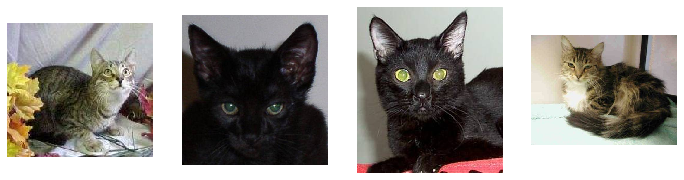

In [4]:
print('sample cat images:')
vis.show_random_images(DATADIR+'/train/cats/') 

sample dog images:


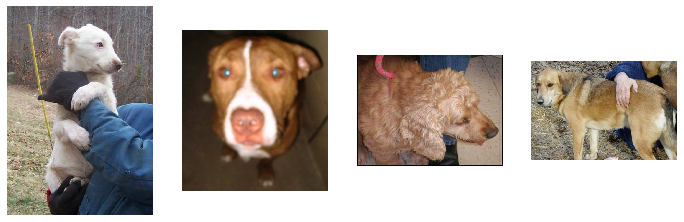

In [5]:
print('sample dog images:')
vis.show_random_images(DATADIR+'/train/dogs/')

Next, we use the ```image_classifier``` function to load a **ResNet50** model pre-trained on [ImageNet](http://www.image-net.org/). For more information on using pretrained networks, see this [blog post](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html). By default, all layers except the randomly initialized custom Dense layers on top are frozen (i.e., trainable).  We, then, wrap the model and data in a Learner object. We specify 4 CPU workers to load batches during training, disable multiprocessing, and use a batch size of 64. You can change these values based on your system specification to see what yields the best peformance. 

In [6]:
# let's print the available precanned image classification models in ktrain
vis.print_image_classifiers()

pretrained_resnet50: 50-layer Residual Network (pretrained on ImageNet)
resnet50: 50-layer Resididual Network (randomly initialized)
pretrained_mobilenet: MobileNet Neural Network (pretrained on ImageNet - TF only)
mobilenet: MobileNet Neural Network (randomly initialized - TF only)
pretrained_inception: Inception Version 3  (pretrained on ImageNet)
inception: Inception Version 3 (randomly initialized)
wrn22: 22-layer Wide Residual Network (randomly initialized)
default_cnn: a default LeNet-like Convolutional Neural Network


In [5]:
model = vis.image_classifier('pretrained_resnet50', train_data, val_data)
learner = ktrain.get_learner(model=model, train_data=train_data, val_data=val_data, 
                             workers=8, use_multiprocessing=False, batch_size=64)

The normalization scheme has been changed for use with a pretrained_resnet50 model. If you decide to use a different model, please reload your dataset with a ktrain.vision.data.images_from* function.

Is Multi-Label? False
pretrained_resnet50 model created.


Next, we freeze the first 15 layers, as the ImageNet pre-trained weights of these early layers are typically applicable as is.  All other layers are unfrozen and trainable. You can use the ```learner.freeze``` and ```learner.unfreeze``` methods to selectively freeze and unfreeze layers, if necessary. ```learner.freeze(freeze_range=15)``` and ```learner.unfreeze(exclude_range=15)``` are equivalent. The number of layers you freeze will depend on how similar your dataset is to ImageNet and other particulars of the dataset. For instance, classifying satellite images or subcellular protein patterns may require less frozen layers than classifying pictures of dogs and cats. You can also begin training for a few epochs with many frozen layers and gradually unfreeze layers for later epochs. 

In [6]:
learner.freeze(freeze_range=15)

You use the ```print_layers``` function to examine the layers of the created network.

In [7]:
learner.print_layers()

0 (trainable=False) : <keras.engine.input_layer.InputLayer object at 0x7fe1a3af6160>
1 (trainable=False) : <keras.layers.convolutional.ZeroPadding2D object at 0x7fe2502275f8>
2 (trainable=False) : <keras.layers.convolutional.Conv2D object at 0x7fe250227668>
3 (trainable=False) : <keras.layers.normalization.BatchNormalization object at 0x7fe1a2d2f470>
4 (trainable=False) : <keras.layers.core.Activation object at 0x7fe1a2d2fdd8>
5 (trainable=False) : <keras.layers.convolutional.ZeroPadding2D object at 0x7fe1a2d4c978>
6 (trainable=False) : <keras.layers.pooling.MaxPooling2D object at 0x7fe1a04cb828>
7 (trainable=False) : <keras.layers.convolutional.Conv2D object at 0x7fe1a2d3eba8>
8 (trainable=False) : <keras.layers.normalization.BatchNormalization object at 0x7fe20c7f9048>
9 (trainable=False) : <keras.layers.core.Activation object at 0x7fe20c7f9f98>
10 (trainable=False) : <keras.layers.convolutional.Conv2D object at 0x7fe20c791470>
11 (trainable=False) : <keras.layers.normalization.Batch

As shown before, we use the Learning Rate Finder in *ktrain* to find a good initial learning rate.

In [8]:
learner.lr_find()

simulating training for different learning rates... this may take a few moments...
Epoch 1/5
359/359 [==============================] - 125s 349ms/step - loss: 1.4328 - acc: 0.5916
Epoch 2/5
359/359 [==============================] - 113s 315ms/step - loss: 0.3350 - acc: 0.8991
Epoch 3/5
231/359 [==================>...........] - ETA: 40s - loss: 0.2776 - acc: 0.9272

done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


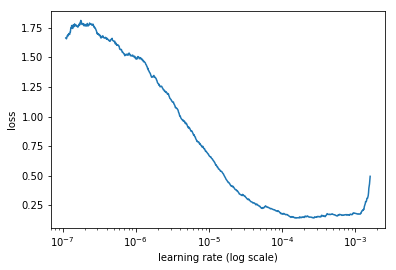

In [9]:
learner.lr_plot()

Finally, we will use the ```autofit``` method to train our model using a [triangular learning rate policy](https://arxiv.org/pdf/1506.01186.pdf). Since we have not specified the number of epochs, the maximum learning
rate will be periodically reduced when validation loss fails to decrease and eventually stop automatically.

Our final validation accuracy is **99.55%** first occuring at the 8th epoch during this run.

In [10]:
learner.autofit(1e-4)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/1024
359/359 [==============================] - 118s 330ms/step - loss: 0.2445 - acc: 0.9304 - val_loss: 0.0401 - val_acc: 0.9870
Epoch 2/1024
359/359 [==============================] - 117s 325ms/step - loss: 0.0778 - acc: 0.9790 - val_loss: 0.0339 - val_acc: 0.9895
Epoch 3/1024
359/359 [==============================] - 117s 325ms/step - loss: 0.0670 - acc: 0.9803 - val_loss: 0.0318 - val_acc: 0.9920
Epoch 4/1024
359/359 [==============================] - 116s 323ms/step - loss: 0.0518 - acc: 0.9846 - val_loss: 0.0334 - val_acc: 0.9895
Epoch 5/1024
359/359 [==============================] - 116s 324ms/step - loss: 0.0530 - acc: 0.9834 - val_loss: 0.0438 - val_acc: 0.9890

Epoch 00005: Reducing Max LR on Plateau: new max lr will be 5e-05 (if not early_stopping).
Epoch 6/1024
359/359 [===========

In [11]:
loss, acc = learner.model.evaluate_generator(learner.val_data, 
                                             steps=len(learner.val_data))

In [12]:
print('final loss:%s, final accuracy:%s' % (loss, acc))

final loss:0.022161634005376185, final accuracy:0.9955


As can be seen, the final validation accuracy of our model is **99.55%**.

### Using Our Model to Make Predictions

Finally, let's use our model to make predictions for some images.

Here is a sample image of both a cat and a dog from the validation set.

In [13]:
!!ls {DATADIR}/valid/cats |head -n3

['cat.10016.jpg', 'cat.1001.jpg', 'cat.10026.jpg']

In [14]:
!!ls {DATADIR}/valid/dogs |head -n3

['dog.10001.jpg', 'dog.10005.jpg', 'dog.10010.jpg']

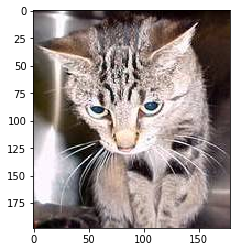

In [15]:
vis.show_image(DATADIR+'/valid/cats/cat.10016.jpg')

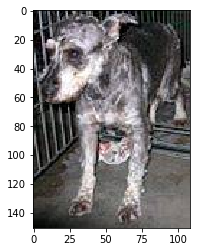

In [16]:
vis.show_image(DATADIR+'/valid/dogs/dog.10001.jpg')

Now, let's create a predictor object to make predictions for the above images.

In [17]:
predictor = ktrain.get_predictor(learner.model, preproc)

Let's see if we predict the selected cat and dog images correctly.

In [18]:
predictor.predict_filename(DATADIR+'/valid/cats/cat.10016.jpg')

['cats']

In [19]:
predictor.predict_filename(DATADIR+'/valid/dogs/dog.10001.jpg')

['dogs']

Our predictor is working well. We can save our predictor to disk for later use in an application.

In [20]:
predictor.save('/tmp/cat_vs_dog_detector')

Let's load our predictor from disk to show that it still works as expected.

In [21]:
predictor = ktrain.load_predictor('/tmp/cat_vs_dog_detector')

In [22]:
predictor.predict_filename(DATADIR+'/valid/cats/cat.10016.jpg')

['cats']

In [23]:
predictor.predict_filename(DATADIR+'/valid/dogs/dog.10001.jpg')

['dogs']

Finally, let's make predictions for all the cat pictures in our validation set:

In [24]:
predictor.predict_folder(DATADIR+'/valid/cats/')[:10]

Found 1000 images belonging to 1 classes.


[('cats/cat.1001.jpg', 'cats'),
 ('cats/cat.10016.jpg', 'cats'),
 ('cats/cat.10026.jpg', 'cats'),
 ('cats/cat.10048.jpg', 'cats'),
 ('cats/cat.10050.jpg', 'cats'),
 ('cats/cat.10064.jpg', 'cats'),
 ('cats/cat.10071.jpg', 'cats'),
 ('cats/cat.10091.jpg', 'cats'),
 ('cats/cat.10103.jpg', 'cats'),
 ('cats/cat.10104.jpg', 'cats')]

By default, `predict*` methods in *ktrain* return  the predicted class labels.  To view the predicted probabilities for each class, supply `return_proba=True` as an extra argument:

```python
predictor.predict_filename(filename, return_proba=True)
predictor.predict_folder(foldername, return_proba=True)
```

## Multi-Label Image Classification

In the previous example, the classes were mutually exclusive.  That is, images contained either a dog or a cat, but not both.  Some problems are multi-label classification problems in that each image can belong to multiple classes (or categories).  One such instance of this is the [Kaggle Planet Competition](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space).  In this competition, were are given a collection of satellite images of the Amazon rainforest.  The objective here is to identify locations of deforestation and human encroachment on forests by classifying images into up to 17 different categories.  Categories include *agriculture*, *habitation*, *selective_logging*, and *slash_burn*. A given satellite image can belong to more than category.  The dataset can be downloaded from the [competition page](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/data). The satellite images are located in a zipped folder called **train-jpg.zip**.  The labels for each image are in the form of a CSV (i.e., **train_v2.csv**) with file names and their labels. Let us first examine the CSV file for this dataset.  Be sure to set the DATADIR variable to the path of the extracted dataset.

In [3]:
DATADIR = 'data/planet'
!!head {DATADIR}/train_v2.csv

['image_name,tags',
 'train_0,haze primary',
 'train_1,agriculture clear primary water',
 'train_2,clear primary',
 'train_3,clear primary',
 'train_4,agriculture clear habitation primary road',
 'train_5,haze primary water',
 'train_6,agriculture clear cultivation primary water',
 'train_7,haze primary',
 'train_8,agriculture clear cultivation primary']

We make three observations.  
* The *image_name* field is the file name of the satellite image. 
* The file names are missing the .jpg file extension.
* The labels are simply a space-delimited list of tags, rather than a one-hot-encoded vector.

Let us first convert this CSV into a new CSV that includes one-hot-encoded representations of the tags and appends the file extension to the file names. Since this dataset format is somewhat common (especially for multi-label image classification problems), *ktrain* contains a convenience function to automatically perform the conversion.  

In [4]:
ORIGINAL_DATA = DATADIR+'/train_v2.csv'
CONVERTED_DATA = DATADIR+'/train_v2-CONVERTED.csv'
labels = vis.preprocess_csv(ORIGINAL_DATA, 
                           CONVERTED_DATA, 
                           x_col='image_name', y_col='tags', suffix='.jpg')

In [5]:
!!head {DATADIR}/train_v2-CONVERTED.csv

['image_name,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water',
 'train_0.jpg,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0',
 'train_1.jpg,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1',
 'train_2.jpg,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0',
 'train_3.jpg,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0',
 'train_4.jpg,1,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0',
 'train_5.jpg,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1',
 'train_6.jpg,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1',
 'train_7.jpg,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0',
 'train_8.jpg,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0']

We can use the ```images_from_csv``` for function to load the data as generators. Remember to specify ```preprocess_for='resenet50'```, as we will be using a ResNet50 architecture again.

In [6]:
train_data, val_data, preproc = vis.images_from_csv(
                          CONVERTED_DATA,
                         'image_name',
                          directory=DATADIR+'/train-jpg',
                          val_filepath = None,
                          label_columns = labels,
                          data_aug=vis.get_data_aug(horizontal_flip=True, vertical_flip=True))


Found 40479 images belonging to 1 classes.
Found 36293 images.
Found 4186 images.


As before, we load a pre-trained ResNet50 model (the default) and wrap this model and the data in a Learner object. Here, will freeze only the first two layers, as the satelitte images are comparatively more dissimilar to ImageNet. Thus, the weights in earlier layers will need more updating.

In [8]:
model = vis.image_classifier('pretrained_resnet50', train_data, val_data=val_data)
learner = ktrain.get_learner(model, train_data=train_data, val_data=val_data, 
                             batch_size=64, workers=8, use_multiprocessing=False)

The normalization scheme has been changed for use with a pretrained_resnet50 model. If you decide to use a different model, please reload your dataset with a ktrain.vision.data.images_from* function.

Is Multi-Label? True
pretrained_resnet50 model created.


In [9]:
learner.freeze(2)

The learning-rate-finder indicates a learning rate of 1e-4 would be a good choice.

In [35]:
learner.lr_find()

simulating training for different learning rates... this may take a few moments...
Epoch 1/5
567/567 [==============================] - 213s 375ms/step - loss: 0.7902 - acc: 0.6997
Epoch 2/5
567/567 [==============================] - 199s 350ms/step - loss: 0.2325 - acc: 0.9208
Epoch 3/5
567/567 [==============================] - 199s 351ms/step - loss: 0.1963 - acc: 0.9371
Epoch 4/5
567/567 [==============================] - 199s 351ms/step - loss: 0.2701 - acc: 0.9098
Epoch 5/5
135/567 [======>.......................] - ETA: 2:35 - loss: 0.4646 - acc: 0.8918

done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


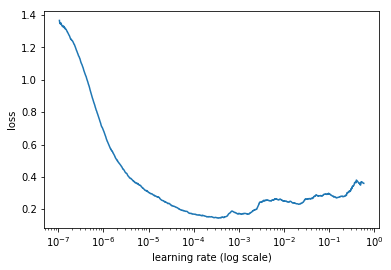

In [36]:
learner.lr_plot()

For this dataset, instead of using ```autofit```, we will use the ```fit_onecycle``` method that utilizes the [1cycle learning rate policy](https://arxiv.org/pdf/1803.09820.pdf). The final model achieves an F2-score of **0.928**, as shown below.

In [10]:
learner.fit_onecycle(1e-4, 20)



begin training using onecycle policy with max lr of 0.0001...
Epoch 1/20
567/567 [==============================] - 219s 386ms/step - loss: 0.2452 - acc: 0.9160 - val_loss: 0.1311 - val_acc: 0.9523
Epoch 2/20
567/567 [==============================] - 206s 363ms/step - loss: 0.1429 - acc: 0.9483 - val_loss: 0.1067 - val_acc: 0.9608
Epoch 3/20
567/567 [==============================] - 206s 364ms/step - loss: 0.1241 - acc: 0.9549 - val_loss: 0.1006 - val_acc: 0.9630
Epoch 4/20
567/567 [==============================] - 206s 364ms/step - loss: 0.1148 - acc: 0.9579 - val_loss: 0.0958 - val_acc: 0.9643
Epoch 5/20
567/567 [==============================] - 205s 362ms/step - loss: 0.1080 - acc: 0.9602 - val_loss: 0.0919 - val_acc: 0.9655
Epoch 6/20
567/567 [==============================] - 205s 361ms/step - loss: 0.1056 - acc: 0.9608 - val_loss: 0.0936 - val_acc: 0.9648
Epoch 7/20
567/567 [==============================] - 205s 362ms/step - loss: 0.1035 - acc: 0.9612 - val_loss: 0.0897 - 

If there is not yet evidence of overfitting, it can sometimes be beneficial to train further after early_stopping.  Since, the validation loss appears to still decrease, we will train for a little more using a lower learning rate. We only train for one additional epoch here for illustration purposes. Prior training, the current model is saved using the ```learner.save_model``` method in case we end up overfitting. If overfitting, the original model can be restored using the ```learner.load_model``` method.

In [15]:
learner.save_model('/tmp/planet_model')

In [16]:
learner.fit_onecycle(1e-4/10,1)



begin training using onecycle policy with max lr of 1e-05...
Epoch 1/1
567/567 [==============================] - 206s 363ms/step - loss: 0.0821 - acc: 0.9684 - val_loss: 0.0835 - val_acc: 0.9693


### Evaluation

The evaluation metric for the [Kaggle Planet competition](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space#evaluation) was the F2-score. 

As shown below, this model achieves an F2-score of **0.928**.


In [17]:
from sklearn.metrics import fbeta_score
import numpy as np
import warnings
def f2(preds, targs, start=0.17, end=0.24, step=0.01):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return max([fbeta_score(targs, (preds>th), 2, average='samples')
                    for th in np.arange(start,end,step)])

In [18]:
y_pred = learner.model.predict_generator(val_data, steps=len(val_data))
y_true = val_data.labels

In [19]:
f2(y_pred, y_true)

0.9284542715011629

### Making Predictions


Let's make some predictions using our model and examine results. As before, we first create a Predictor instance.

In [22]:
predictor = ktrain.get_predictor(learner.model, preproc)

Let's examine the folder of images and select a couple to analyze.

In [23]:
!!ls {DATADIR}/train-jpg/ |head

['train_0.jpg',
 'train_10000.jpg',
 'train_10001.jpg',
 'train_10002.jpg',
 'train_10003.jpg',
 'train_10004.jpg',
 'train_10005.jpg',
 'train_10006.jpg',
 'train_10007.jpg',
 'train_10008.jpg']

Image train_10008.jpg is categorized into the following classes: 
* artisinal_mine (i.e., small-scale mining operations - sometimes illegal in lands designated for conservation)
* clear
* primary (rainforest)
* water

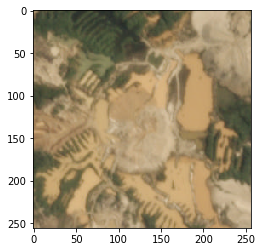

In [40]:
vis.show_image(DATADIR+'/train-jpg/train_10008.jpg')

In [43]:
!!head -n 1 {CONVERTED_DATA}

['image_name,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water']

In [44]:
!!grep train_10008.jpg {CONVERTED_DATA}

['train_10008.jpg,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1']

Our predictions are consistent as shown below:

In [45]:
predictor.predict_filename(DATADIR+'/train-jpg/train_10008.jpg')

[[('agriculture', 0.0040258057),
  ('artisinal_mine', 0.99988484),
  ('bare_ground', 0.041586075),
  ('blooming', 3.7402046e-07),
  ('blow_down', 3.65358e-08),
  ('clear', 0.99841964),
  ('cloudy', 2.9288345e-05),
  ('conventional_mine', 0.0185931),
  ('cultivation', 0.0033639816),
  ('habitation', 0.011448876),
  ('haze', 0.00052912283),
  ('partly_cloudy', 0.0012023835),
  ('primary', 0.9873427),
  ('road', 0.21895583),
  ('selective_logging', 3.939015e-05),
  ('slash_burn', 2.703976e-05),
  ('water', 0.9984894)]]

Here is another example showing water, clear, and primary.

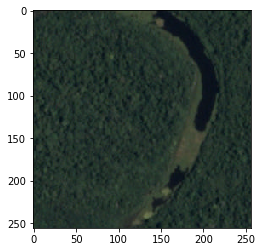

In [46]:
vis.show_image(DATADIR+'/train-jpg/train_10010.jpg')

In [47]:
!!head -n 1 {CONVERTED_DATA}

['image_name,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water']

In [48]:
!!grep train_10010.jpg {CONVERTED_DATA}

['train_10010.jpg,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1']

In [49]:
predictor.predict_filename(DATADIR+'/train-jpg/train_10010.jpg')

[[('agriculture', 0.26275295),
  ('artisinal_mine', 0.0002662742),
  ('bare_ground', 0.00402921),
  ('blooming', 0.00014191697),
  ('blow_down', 7.4397904e-06),
  ('clear', 0.998609),
  ('cloudy', 1.0647154e-06),
  ('conventional_mine', 4.7428235e-05),
  ('cultivation', 0.08935747),
  ('habitation', 0.010819469),
  ('haze', 3.7207883e-05),
  ('partly_cloudy', 0.0010312625),
  ('primary', 0.99998605),
  ('road', 0.06903103),
  ('selective_logging', 0.0035000525),
  ('slash_burn', 0.0003681789),
  ('water', 0.9974711)]]